In [1]:
# internal imports
import os
import sys

# essential packages imports
import random
import numpy as np
from numpy.typing import NDArray
from typing import Tuple
import pandas as pd
import scipy.stats
from tqdm import tqdm
from datetime import datetime

# NN/DL frameworks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchsummary import summary
import lightning as PL

# visualization, image manipulation packages
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, transform

In [2]:
# Set seed.
seed = 42
PL.pytorch.seed_everything(seed, workers=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)

Global seed set to 42


# Data Prelimenary Investigation

In this section we would like to investigate the data visually as well as getting an idea about the two variables in our csv file.

In [3]:
# open the csv as a dataframe
df = pd.read_csv('./data/CodingChallenge_v2/car_imgs_4000.csv')

In [4]:
# basic dataframe infos
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   filename                         4000 non-null   object 
 1   perspective_score_hood           4000 non-null   float64
 2   perspective_score_backdoor_left  4000 non-null   float64
dtypes: float64(2), object(1)
memory usage: 93.9+ KB


,filename,perspective_score_hood,perspective_score_backdoor_left
0,66ee2d88-f403-4821-a370-8a3d72e200f9.jpg,0.27352,0.439526
1,bf7e237e-f12b-4ffc-8d79-6855cc35ea06.jpg,0.00000,0.902682
2,4c297488-c81f-464d-92bf-1c408333a912.jpg,0.00000,0.900864
3,6c95ad0b-fda6-42a8-a33d-b430073e1dcd.jpg,0.00000,0.213162
4,bd806d94-4c2e-4cd2-8e02-5eaba7c7c63e.jpg,0.00000,0.818388


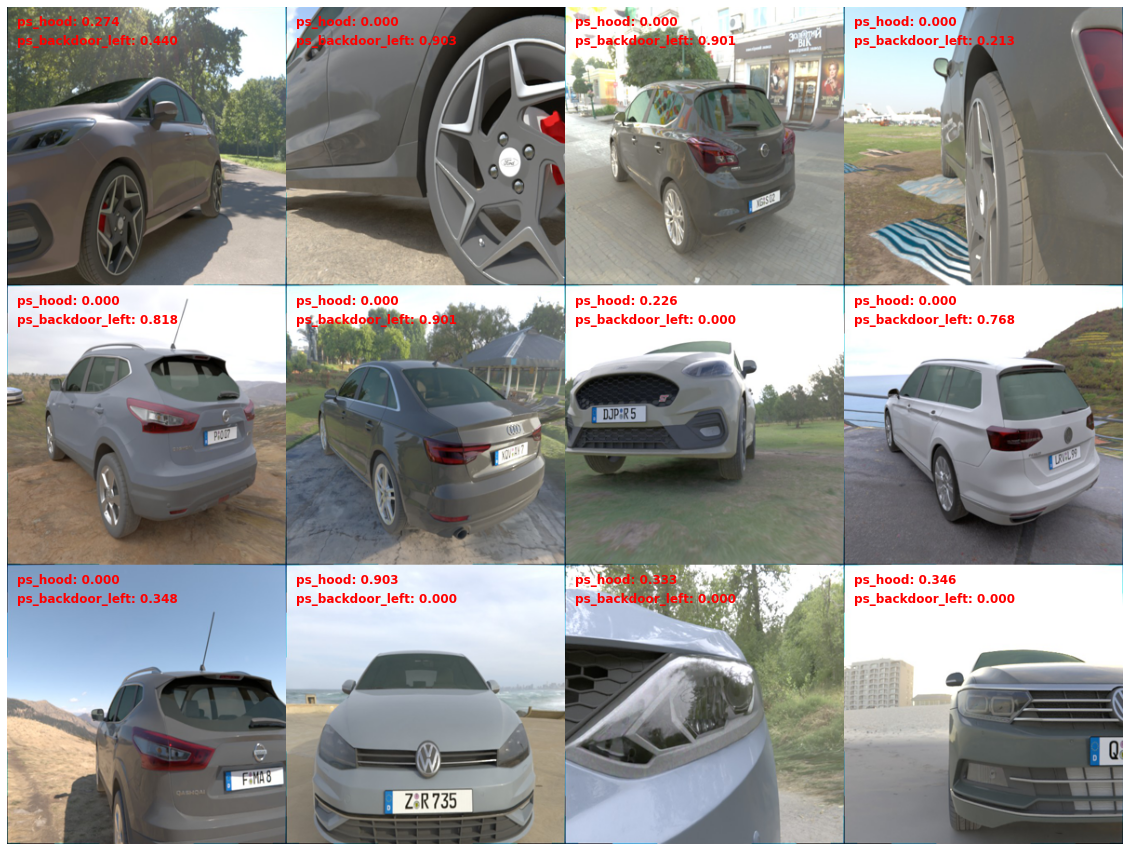

In [5]:
# basic sample images and variables investigation

# const for defining the number of rows in our visualization grid
N_COLS = 4
# const for the overall number of images we want to visualize
N_IMGS = 12

def img_reshape(img: str) -> NDArray:
    """Open and reshape image to a certain size
    Attributes:
    -----------
    img: str
        path to the image file
    """
    img = Image.open(img).convert('RGB')
    img = img.resize((300,300))
    # we convert the PIL image to a numpy array
    img = np.asarray(img)
    return img

def image_grid(array: NDArray, ncols: int) -> NDArray:
    """Create a concatenation of images as a grid
    Attributes:
    -----------
    array: NDArray
        array containing the images' array
    ncols: int
        number of columns in the grid
    """
    # get the 4 shape components from the input array
    index, height, width, channels = array.shape
    # calculate the number of rows based on the given ncols and the index (#images)
    nrows = index//ncols
    
    # build the grid of images by reshaping the input array
    # swapping the third and second axis (height and ncols)
    # then reshaping the whole array to include all images
    img_grid = (array.reshape(nrows, ncols, height, width, channels)
                .swapaxes(1, 2).reshape(height*nrows, width*ncols, channels))
    
    return img_grid


# get some sample images from the images path
img_arr = [img_reshape(os.path.join('./data/CodingChallenge_v2/imgs/', filename)) for filename in df.filename.values[:N_IMGS]]
# get some sample perspective_score_hood from the df
ps_hood = [score for score in df.perspective_score_hood.values[:N_IMGS]]
# get some sample perspective_score_backdoor_left from the df
ps_backdoor_left = [score for score in df.perspective_score_backdoor_left.values[:N_IMGS]]

# building the grid of images
result = image_grid(np.array(img_arr), N_COLS)
fig = plt.figure(figsize=(20., 20.))

# adding the annotation (ps_hood and ps_backdoor_left) on top of the images
x = 10
y = 20
for i, (score_hood, score_bl) in enumerate(zip(ps_hood, ps_backdoor_left)):
    if i % N_COLS == 0 and i != 0:
        x = 10
        y += 300
    plt.text(x, y, f'ps_hood: {score_hood:.3f}', color='red', size='large', weight='bold')
    plt.text(x, y + 20, f'ps_backdoor_left: {score_bl:.3f}', color='red', size='large', weight='bold')
    x += 300
        

plt.imshow(result)
plt.axis('off')
plt.show()

# Distribution Analysis: ps_hood and ps_backdoor_left
In this section we would like to go a little further by investigating the distribution and relationship of the two variables "perspective_score_hood" and "persepective_score_backdoor_left", this will allow us to have a better understanding of these two variables as well as a guided decision of what should we take care of in our DL implementation.

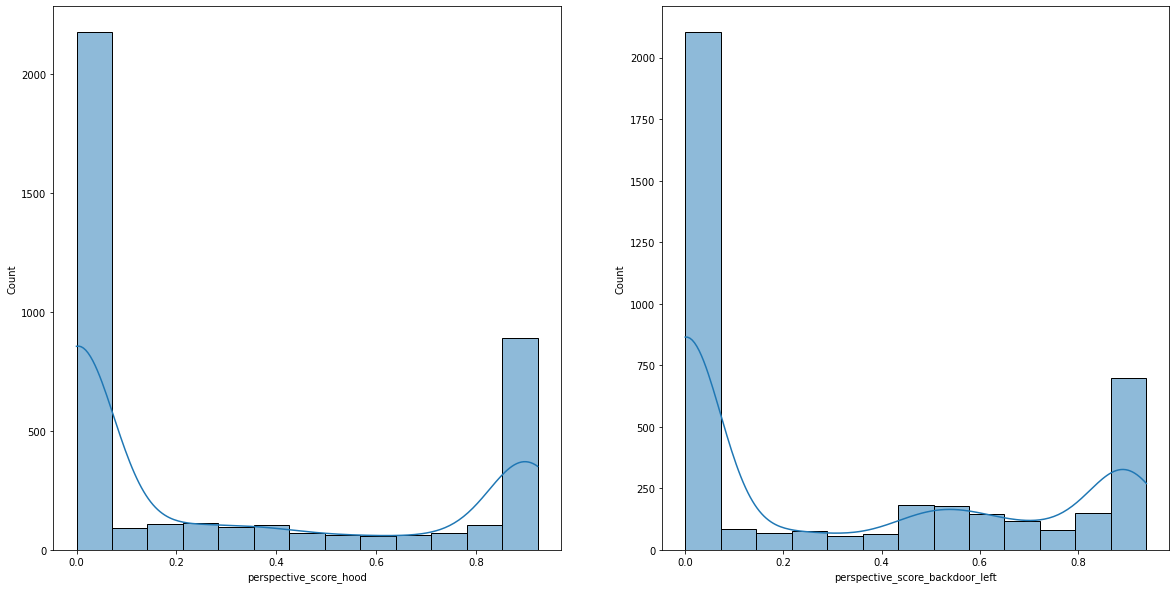

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(20., 10.))
sns.histplot(df, x='perspective_score_hood', kde=True, ax=axs[0])
sns.histplot(df, x='perspective_score_backdoor_left', kde=True, ax=axs[1])
plt.show()

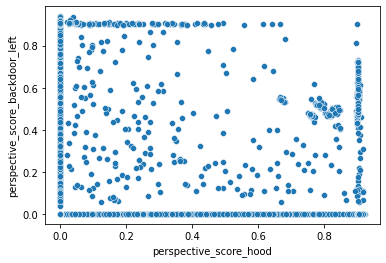

In [7]:
sns.scatterplot(data=df, x='perspective_score_hood', y='perspective_score_backdoor_left')
plt.show()

In [8]:
print("ps_hood std: ", df.perspective_score_hood.std())
print("ps_hood mean: ", df.perspective_score_hood.mean())
print("ps_backdoor_left std: ", df.perspective_score_backdoor_left.std())
print("ps_backdoor_left mean: ", df.perspective_score_backdoor_left.mean())

ps_hood std:  0.38258234586659956
ps_hood mean:  0.30303198100175
ps_backdoor_left std:  0.3723338886237746
ps_backdoor_left mean:  0.31336786319750004


In [9]:
#df.iloc[:,1:] = df.iloc[:,1:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
#print("ps_hood std: ", df.perspective_score_hood.std())
#print("ps_hood mean: ", df.perspective_score_hood.mean())
#print("ps_backdoor_left std: ", df.perspective_score_backdoor_left.std())
#print("ps_backdoor_left mean: ", df.perspective_score_backdoor_left.mean())

In [10]:
# correlation analysisusing two popular approachs
corr_pears = df.perspective_score_hood.corr(df.perspective_score_backdoor_left)
corr_kendal = df.perspective_score_hood.corr(df.perspective_score_backdoor_left, method='kendall')

# we can notice a slight but rather obvious negative correlation between the two vars
print(f'corr_pears: {corr_pears}')
print(f'corr_kendal: {corr_kendal}')

corr_pears: -0.21201307499656402
corr_kendal: -0.17980745401329748


# Data preparation
In this section, we will start by creating our customized dataset, dataloader and split the dataset on 3 parts:
* Training (80%)
* Validation (10%)
* Testing (10%)

We will also take a look at a batch of samples from our dataset and dataloader to check that everything is as expected.

In [11]:
class VehiclesDataset(Dataset):
    """Vehicles dataset."""

    def __init__(self, csv_file: str, root_dir: str, transform: callable=None):
        """init function of the VehiclesDataset class
        Attributes:
        -----------
        csv_file: str
            Path to the csv file with images filenames, perspective_score_hood and perspective_score_backdoor_left variables.
        root_dir: str
            Directory with all the images.
        transform: callable, optional
            Optional transform to be applied on a sample.
        """
        self.vehicles_info = pd.read_csv(os.path.join(root_dir, csv_file))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.vehicles_info)

    def __getitem__(self, idx):
        # make sure to convert the indices of items to lists instead of pytorch tensors
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # build the path to the chosen image
        img_name = os.path.join(self.root_dir,'imgs/',
                                self.vehicles_info.iloc[idx, 0])
        #open the image
        image = io.imread(img_name)
        #image = np.asarray(Image.open(img_name).convert('RGB'))
        # get the perspective_score_hood from the df, convert to numpy array
        ps_hood = np.array(self.vehicles_info.iloc[idx, 1], dtype=float)
        # get the perspective_score_backdoor_left from the df, convert to np array
        ps_backdoor_left = np.array(self.vehicles_info.iloc[idx, 2], dtype=float)
        # build the dictionary of selected elements
        sample = {'image': image, 'ps_hood': ps_hood, 'ps_backdoor_left': ps_backdoor_left}
        
        # apply transformations on the sample if any provided
        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample: dict):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = sample['image'].transpose((2, 0, 1))
        # convert every attribute to a torch tensor
        return {'image': torch.from_numpy(image).float(),
                'ps_hood': torch.from_numpy(sample['ps_hood']).float(),
                'ps_backdoor_left': torch.from_numpy(sample['ps_backdoor_left']).float()}

#class Normalize(object):
#    """normalize images using the mean and std."""
    
#    def __init__(self, mean: list, std: list):
#        self.mean = mean
#        self.std = std
    
#    def __call__(self, sample: dict):
        
#        sample['image'] = transforms.functional.normalize(sample['image'], self.mean, self.std)
#        return sample
    
def split(full_dataset: Dataset, val_percent: float, test_percent: float, random_seed: int=None) -> Tuple[Dataset, Dataset, Dataset]:
    """split the full dataset into train, validation and test
    Attributes:
    -----------
    full_dataset: Dataset
        the full dataset object
    val_percent: float
        a value in [0, 1] representing the percentage of the validation data to take from the full_dataset
    test_percent: float
        a value in [0, 1] representing the percentage of the test data to take from the full_dataset
    random_seed: int, optional
        a random seed for reproducibility
    """
    # full length of dataset
    amount = len(full_dataset)

    # calculate the number of test samples
    test_amount = (
        int(amount * test_percent)
        if test_percent is not None else 0)
    # calculate the number of validation samples
    val_amount = (
        int(amount * val_percent)
        if val_percent is not None else 0)
    # calculate the number of training samples
    train_amount = amount - test_amount - val_amount

    # use pytorch random_split function to split the dataset
    # use a pytorch generator with a defined seed for reproducibility
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        (train_amount, val_amount, test_amount),
        generator=(
            torch.Generator().manual_seed(random_seed)
            if random_seed
            else None))
    
    return train_dataset, val_dataset, test_dataset

In [12]:
vehicles_dataset = VehiclesDataset(csv_file='car_imgs_4000.csv', 
                                   root_dir='./data/CodingChallenge_v2/')

transformed_dataset = VehiclesDataset(csv_file='car_imgs_4000.csv', 
                                      root_dir='./data/CodingChallenge_v2/',
                                      transform=transforms.Compose([
                                           ToTensor(),
                                           #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ]))

Image #0 shape: (506, 674, 3)


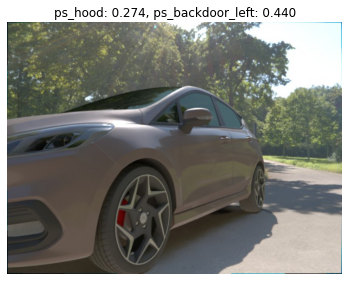

Image #1 shape: (506, 674, 3)


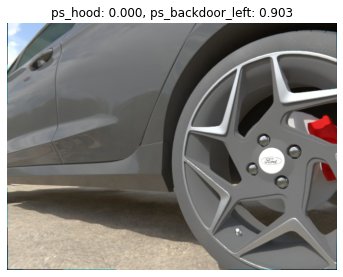

Image #2 shape: (506, 674, 3)


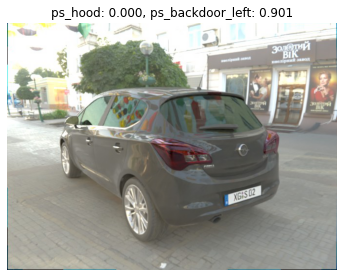

Image #3 shape: (506, 674, 3)


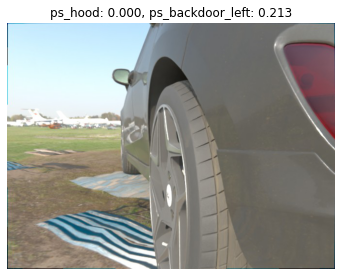

In [13]:
# some visual investigation of the dataset
for i, sample in enumerate(vehicles_dataset):
    fig = plt.figure(figsize=(20., 20.))
    print(f'Image #{i} shape: {sample["image"].shape}')

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'ps_hood: {sample["ps_hood"]:.3f}, ps_backdoor_left: {sample["ps_backdoor_left"]:.3f}')
    ax.axis('off')
    plt.imshow(sample['image'])
    plt.pause(0.001)

    if i == 3:
        plt.show()
        break

In [14]:
# simple check if our transformation is working
for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size())

    if i == 3:
        break

0 torch.Size([3, 506, 674])
1 torch.Size([3, 506, 674])
2 torch.Size([3, 506, 674])
3 torch.Size([3, 506, 674])


0 torch.Size([4, 3, 506, 674])
1 torch.Size([4, 3, 506, 674])
2 torch.Size([4, 3, 506, 674])
3 torch.Size([4, 3, 506, 674])


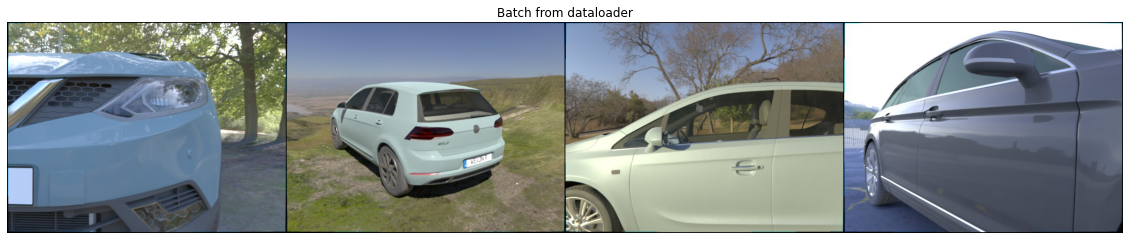

In [15]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=os.cpu_count())

# Helper function to show a batch
def show_batch(sample_batched: dict):
    """Show images for a batch of samples.
    Attributes:
    -----------
    sample_batched: dict
        batch of samples including the image
    """
    # get images from the batch
    images_batch = sample_batched['image']

    # make a grid using the 
    grid = utils.make_grid(images_batch)
    # show image
    grid = grid.numpy().transpose((1, 2, 0))/255.
    plt.imshow(grid)
    plt.title('Batch from dataloader')


for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(20., 20.))
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# Neural Network Architecture
Here we will build a deep neural network architecture for multi-output regression based on a vanilla [ResNET18](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) architecture.\
I chose to make the (last) output layer as a linear (dense) layer of 2 components output variables instead of separating these two.\
This decision is based on the previous analysis and investigation that the two variables may have a relationship and therefore it is more sensible to be learned together.\
The choice of ResNET18 is based on mainly the following reasons:
- ResNET18 is an efficient choice: I can run the training on my small NVIDIA GeForce 1050Ti GPU.
- ResNET is a good feature extractor: the architecture, with pre-trained weights or trained from scratch, is a used in many applications as a backbone model.
- Given the size of the dataset (3200 images for training) it is a good approach to go with a small variant of the ResNET architecture and that is the ResNET18.


For the training settings and logic, PyTorch Lightning will be used. It is a wrapper of PyTorch modules and offers out-of-the-box training, validation and testing logic. Easy to implement and cleaner code to debug and maintain. Every PyTorch type is natively compatible with PyTorch Lightning.

In [16]:
# create a basic residual block for the ResNET architecture
class ResBlock(nn.Module):
    """Residual or basic block for building ResNET architectures."""
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, inputs):
        shortcut = self.shortcut(inputs)
        x = nn.ReLU()(self.bn1(self.conv1(inputs)))
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = x + shortcut
        return nn.ReLU()(x)

class MOM_ResNET18(nn.Module):
    """Multi-Output-Model(MOM) with ResNET18 as backbone for feature extraction."""
    def __init__(self, in_channels, resblock):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 2)

    def forward(self, inputs):
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)

        return x

# PyTorchLightning(Lit) wrapper of the MOM_ResNET18 architecture
class LitMOM_ResNET18(PL.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr  
        
    def shared_step(self, batch, batch_idx):
        image, ps_hood, ps_bl = batch['image'].to(self.device),\
                                batch['ps_hood'].to(self.device),\
                                batch['ps_backdoor_left'].to(self.device)
        y_hat = self.model(image)
        y = torch.stack([ps_hood, ps_bl]).transpose(1, 0)
        loss = F.mse_loss(y_hat, y)
        acc = 100 - torch.mean(torch.abs(y_hat - y))*100
        return {"loss": loss, "acc": acc}
    
    def shared_epoch_end(self, outputs, stage):

        # aggregate step metrics
        loss = torch.tensor([output["loss"] for output in outputs])
        acc = torch.tensor([output["acc"] for output in outputs])

        # calculate the metrics' mean
        m_loss = torch.mean(loss)
        m_acc = torch.mean(acc)

        metrics = {
            f"{stage}_loss": m_loss,
            f"{stage}_acc": m_acc
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        self.eval()
        with torch.no_grad():
            return self.shared_step(batch, batch_idx)
        
    def test_step(self, batch, batch_idx):
        self.eval()
        with torch.no_grad():
            return self.shared_step(batch, batch_idx)
    
    def predict_step(self, batch, batch_idx):
        self.eval()
        with torch.no_grad():
            inputs = batch['image'].to(self.device)
            targets = torch.stack([batch['ps_hood'].to(self.device), 
                                   batch['ps_backdoor_left'].to(self.device)]).transpose(1, 0)
            outputs = {"prediction": self.model(inputs),
                       "target": targets}
            return outputs
        
    def training_epoch_end(self, outputs):
        self.shared_epoch_end(outputs, "train")

    def validation_epoch_end(self, outputs):
        self.shared_epoch_end(outputs, "valid")

    def test_epoch_end(self, outputs):
        self.shared_epoch_end(outputs, "test")
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [17]:
class MyProgressBar(PL.pytorch.callbacks.TQDMProgressBar):
    """Custom progress bar"""
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

    def init_predict_tqdm(self):
        bar = super().init_predict_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

    def init_test_tqdm(self):
        bar = super().init_test_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

In [18]:
# training parameters.
epochs = 100
batch_size = 4
lr = 1e-4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
val_percent = 0.1
test_percent = 0.1

# checkpoint for saving model states
checkpoint_callback = PL.pytorch.callbacks.ModelCheckpoint(
                            monitor='valid_loss',
                            dirpath=os.path.join('./data/checkpoints/', datetime.now().strftime("%d%m%YT%H%M%S")),
                            filename='{epoch:02d}-{valid_loss:.3f}',
                            save_top_k=3,
                            mode='min')


trainset, valset, testset = split(transformed_dataset, val_percent, test_percent, random_seed=seed)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
validloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [38]:
# create pytorch model
model = MOM_ResNET18(3, ResBlock)
model.to(device)
#summary(model, (3, 506, 674))

# include the pytorch model to lightning
lit_model = LitMOM_ResNET18(model=model, lr=lr)

# create a tensorboard logger for tracking training/validation metrics
logger = PL.pytorch.loggers.TensorBoardLogger("tb_logs", name="momresnet18")

# create PytorchLightning Trainer
trainer = PL.Trainer(deterministic=True, accelerator="gpu", devices=1, 
                     callbacks=[MyProgressBar(), checkpoint_callback], 
                     max_epochs=epochs, logger=logger)
# start training
trainer.fit(lit_model, train_dataloaders=trainloader, val_dataloaders=validloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | MOM_ResNET18 | 11.2 M
---------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.729    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/mohamed/.virtualenvs/master_venv/lib/python3.7/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/mohamed/.virtualenvs/master_venv/lib/python3.7/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/mohamed/.virtualenvs/master_venv/lib/python3.7/site-packages/lightning/pytorch/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [19]:
model = MOM_ResNET18(3, ResBlock)
model.to(device)

# load pretrained weights
lit_model = LitMOM_ResNET18(model=model, lr=lr)
lit_model = lit_model.load_from_checkpoint("./data/checkpoints/07012024T175823/epoch=98-valid_loss=0.018.ckpt", 
                                           model=model)
# create PytorchLightning Trainer
trainer = PL.Trainer(deterministic=True, accelerator="gpu", devices=1)
# run test
out_metrics = trainer.test(model=lit_model, dataloaders=testloader)
outputs = trainer.predict(model=lit_model, dataloaders=testloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-01-08 18:24:11.890296: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/home/mohamed/.virtualenvs/master_venv/lib/python3.7/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     91.90562438964844     │
│         test_loss         │    0.0162556990981102     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mohamed/.virtualenvs/master_venv/lib/python3.7/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

In [23]:
for output in outputs:
    print("Prediction: \n", output['prediction'].numpy())
    print("--"*30)
    print("Target: \n", output['target'].numpy())
    print("\n")
    print("=="*30)

Prediction: 
 [[-0.0177768   0.24050334]
 [ 0.43655825  0.3470915 ]
 [ 0.8328788   0.48828754]
 [-0.05625509  0.8466746 ]]
------------------------------------------------------------
Target: 
 [[0.         0.        ]
 [0.90345097 0.        ]
 [0.900752   0.42941868]
 [0.         0.9009963 ]]


Prediction: 
 [[0.78421944 0.478176  ]
 [0.6051548  0.05533681]
 [0.01469562 0.02369685]
 [0.7968294  0.5171249 ]]
------------------------------------------------------------
Target: 
 [[0.84791124 0.40642017]
 [0.60626817 0.        ]
 [0.         0.        ]
 [0.6645528  0.54837275]]


Prediction: 
 [[ 0.9175841   0.56320834]
 [ 0.6266799   0.09301043]
 [-0.00452485  0.80754954]
 [-0.02363263  0.8468037 ]]
------------------------------------------------------------
Target: 
 [[0.90604454 0.58854747]
 [0.9015243  0.        ]
 [0.         0.8297041 ]
 [0.         0.8999112 ]]


Prediction: 
 [[-0.08260023  0.7244434 ]
 [ 0.1223105   0.90422916]
 [ 0.17473324  0.4473149 ]
 [ 0.8808489   0.00227